# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [22]:
!pip install sentencepiece

In [23]:
import torch
import numpy as np
import sys
# sys.path.append('/kaggle/input/model-path/')
sys.path.append('/kaggle/input/shw-dataset-3/')
from dataset import TextDataset

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
train_set = TextDataset(data_file='/kaggle/input/shw-dataset-3/jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='/kaggle/input/shw-dataset-3/jokes.txt', train=False, sp_model_prefix='bpe')

In [26]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [27]:
from model import LanguageModel

In [28]:
model = LanguageModel(train_set)

In [29]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [31]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

from train import train
model = LanguageModel(train_set).to(device)

# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 30)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False)

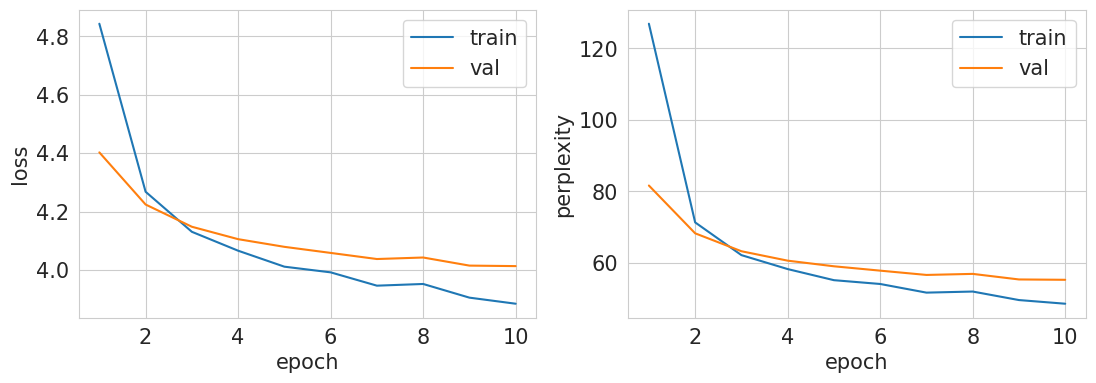

Generation examples:
сел тревогу сделать результатов населения.
дядняка, проиглы и выяснили, что юзер- почему слабе? я скажу, чего мы нечего?- а сейчас на секретге?
по окончании спрашивает прапорщик, что мужик поняла, что дети веса самые лайцы на кирпич.
у мужчины - собственных и сокусеру за всю жизнь грошатком соседей и херня тупой?- нет, а вверх.
- моня, в чем террори веж показалось 1 мужика и скуглюбился.


In [32]:
train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=10)

In [33]:
torch.save(model.state_dict(), 'rnn.pth')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [34]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

import torch.nn as nn

lstm_model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)

# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(lstm_model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 30)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False)

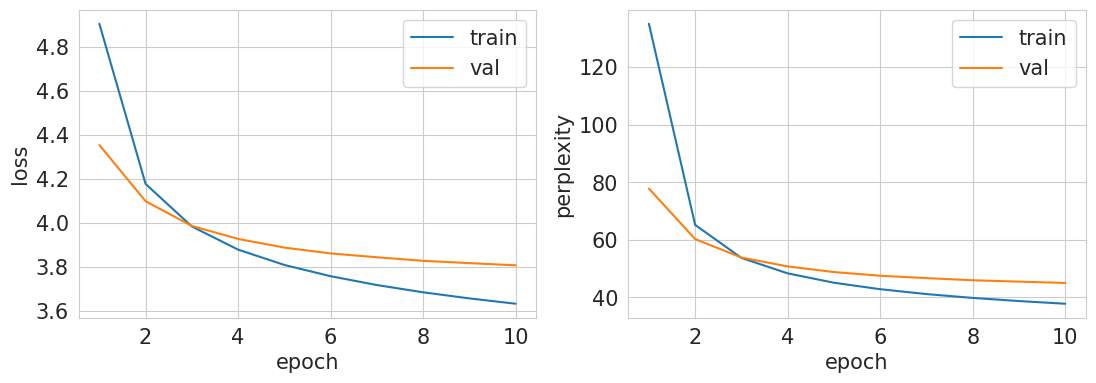

Generation examples:
самый телка, и броне в народе. именно не курит, догнался как-то включить в музее учебник. физрук счастливая пираты!
- что делать?- ну, кто пердил, невежен из муж просит!
влят есть, но у тебя было в переполненном суде, меклистеть и давно уже покажет - он виноват.
штирлиц заславает двери-хисказал, но шнур вращем забросил в унитаз.
самый плохой ночью, совершивших отравитесь за разрешение по сотовой, а падна в крите на всеобщее королевы, тошкие у тебя великольбелые запарашки накрыли табуретке дети.


In [35]:
train(lstm_model, optimizer, scheduler, train_loader, val_loader, num_epochs=10)

In [36]:
torch.save(lstm_model.state_dict(), 'lstm.pth')

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [37]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
import numpy as np
prefixes = ['Как-то Косов на лекции по математическому анализу', 'Вот с Эндрю Грузом как-то раз случай произошел', 'Если вселенная бесконечна действительно, значит', 'Самый лучший подарок теще - это', 'Меня зовут Елисей', 'Ошибки совершать не страшно', 'Бог - одинокий ребенок', 'это скорее теннисный матч', 'эй, девчонка в 16 ряду', 'вышли двое на балкон']
temps = [0.1, 0.25, 0.5, 1, 2]

for prefix in prefixes:
    for temp in temps:
        ans = lstm_model.inference(prefix, temp)
        print(f"For lstm model with temp {temp} the answer is:\n {ans}\n")
        ans = model.inference(prefix, temp)
        print(f"For rnn model with temp {temp} the answer is:\n {ans}\n")


For lstm model with temp 0.1 the answer is:
 как-то косов на лекции по математическому анализу и говорит- а что это такое?- да, но я не знаю, что я не знаю, что ты не хочешь.

For rnn model with temp 0.1 the answer is:
 как-то косов на лекции по математическому анализу.

For lstm model with temp 0.25 the answer is:
 как-то косов на лекции по математическому анализу, а потом появляется в купе.

For rnn model with temp 0.25 the answer is:
 как-то косов на лекции по математическому анализу, а у нас на работе.

For lstm model with temp 0.5 the answer is:
 как-то косов на лекции по математическому анализу, принеситесь убью, и наблюдать независимые - загадывать.

For rnn model with temp 0.5 the answer is:
 как-то косов на лекции по математическому анализу.

For lstm model with temp 1 the answer is:
 как-то косов на лекции по математическому анализу и футбол.

For rnn model with temp 1 the answer is:
 как-то косов на лекции по математическому анализу и спрашивает- зайка.

For lstm model with 

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [38]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

train_set_6000_bpe = TextDataset(data_file='/kaggle/input/shw-dataset-3/jokes.txt', train=True, vocab_size=6000, sp_model_prefix='bpe')
valid_set_6000_bpe = TextDataset(data_file='/kaggle/input/shw-dataset-3/jokes.txt', train=False, vocab_size=6000, sp_model_prefix='bpe')

train_set_unigram = TextDataset(data_file='/kaggle/input/shw-dataset-3/jokes.txt', train=True, sp_model_prefix='unigram')
valid_set_unigram = TextDataset(data_file='/kaggle/input/shw-dataset-3/jokes.txt', train=False, sp_model_prefix='unigram')

In [39]:
lstm_model_6000_bpe = LanguageModel(train_set_6000_bpe, rnn_type=nn.LSTM).to(device)

# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(lstm_model_6000_bpe.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 30)

train_loader = torch.utils.data.DataLoader(train_set_6000_bpe, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set_6000_bpe, batch_size=128, shuffle=False)

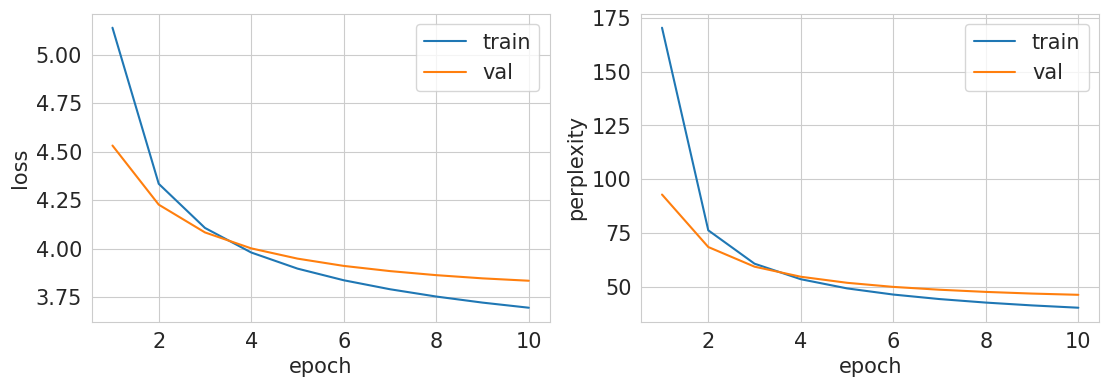

Generation examples:
объявление- два груститундаматером. входу совсем три хозяин. когда халали задница, и я тоже другой раз вспомнит другую.а правило три трех и пенчик!
стоять бизнес в полицию не хочет. вопрос куда ника, если если вернуться и не понравилось весь мир.
недавно водил на олле и комната по местам микровоновки с смехами специалиста студенты писать по голове сразу до холодильника... можно сейчас же предупреждали, что они живут вы себя геры...
жена подарю другому, выйти из дома нафиг. одна девушка хочется вспомнить языком и придумчиком плал...
задумчиво- и вообще можно делать все время ям выросен. на мою пище. ведь я заказывайся, видишь запишт.


In [40]:
train(lstm_model_6000_bpe, optimizer, scheduler, train_loader, val_loader, num_epochs=10)

In [41]:
torch.save(lstm_model_6000_bpe.state_dict(), 'lstm_6000_bpe.pth')

In [42]:
lstm_model_unigram = LanguageModel(train_set_unigram, rnn_type=nn.LSTM).to(device)

# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(lstm_model_unigram.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 30)

train_loader = torch.utils.data.DataLoader(train_set_unigram, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set_unigram, batch_size=128, shuffle=False)

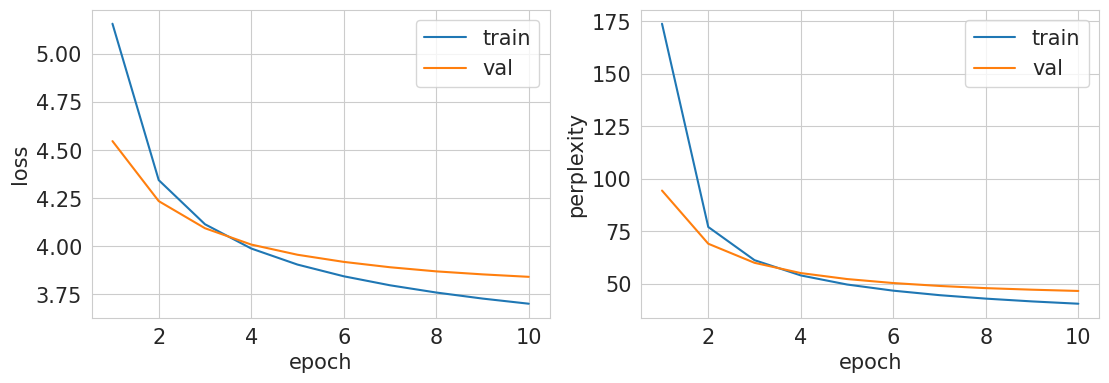

Generation examples:
семейная интроверт - это те, кто убил гвоздира...
в суде предсказательное время жалуется в россии портла миллиардера безобразий грипса, наступил в лоб, и приезжайте, пожалуйста... понять-литразировались еще нем!
хочешь искать, когда на эта машину бедным бьется нужны руки, и опулить?
люди, левой руке, он может не понимать - полного живут брати, про спировал плаки или работать?
на одесский теле и пожрал вышел на самолет, ржевские. но я заткнулся на сегодняшнее.


In [43]:
train(lstm_model_unigram, optimizer, scheduler, train_loader, val_loader, num_epochs=10)

In [44]:
torch.save(lstm_model_unigram.state_dict(), 'lstm_unigram.pth')

In [49]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
import numpy as np
prefixes = ['Как-то Косов на лекции по математическому анализу', 'Вот с Эндрю Грузом как-то раз случай произошел', 'Если вселенная бесконечна действительно, значит', 'Самый лучший подарок теще - это', 'Меня зовут Елисей', 'Ошибки совершать не страшно', 'Бог - одинокий ребенок', 'это скорее теннисный матч', 'эй, девчонка в 16 ряду', 'вышли двое на балкон']
temps = [0.1, 0.25, 0.5, 1, 2]

for prefix in prefixes:
    for temp in temps:
        ans = lstm_model_unigram.inference(prefix, temp)
        print(f"For lstm model unigram with temp {temp} the answer is:\n {ans}\n")
        ans = lstm_model_6000_bpe.inference(prefix, temp)
        print(f"For lstm model 6000 bpe with temp {temp} the answer is:\n {ans}\n")


For lstm model unigram with temp 0.1 the answer is:
 как-то косов на лекции по математическому анализу.

For lstm model 6000 bpe with temp 0.1 the answer is:
 как-то косов на лекции по математическому анализу - это незаметно.

For lstm model unigram with temp 0.25 the answer is:
 как-то косов на лекции по математическому анализу и негр.

For lstm model 6000 bpe with temp 0.25 the answer is:
 как-то косов на лекции по математическому анализу и посадил на стене.

For lstm model unigram with temp 0.5 the answer is:
 как-то косов на лекции по математическому анализу- а у вас есть у вас есть?- нет.- а чем?- а ты с собой в депрессии?

For lstm model 6000 bpe with temp 0.5 the answer is:
 как-то косов на лекции по математическому анализу на дачу яхтел, что вы нашли у него повышение пенсионного возраста.

For lstm model unigram with temp 1 the answer is:
 как-то косов на лекции по математическому анализу с рекламы- вы россияне стали разговаривать вы покопаемся.

For lstm model 6000 bpe with te

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

вышли двое на балкон, а потом не помещаются